In [11]:
import os
import pandas as pd
import numpy as np
import random
from music21 import converter
import matplotlib.pyplot as plt
import seaborn as sns

# Task A

In [12]:
# Function to parse an annotation file
def parse_annotation(path):
    timestamps = []
    beats = []
    first_db = -1
    beat_cnt = 0
    with open(path, "r") as file:
        beat_id = 1
        time_signature = ''
        for i, line in enumerate(file):
            elements = line.split()
            timestamps.append(float(elements[0]))
            if elements[2].startswith('db'):
                beat_id = 1
                if first_db == -1:
                    first_db = i
                subelements = elements[2].split(',')
                for e in subelements:
                    if '/' in e:
                        if time_signature == '':
                            time_signature = e
                        else:
                            raise ValueError("Do not support time signature change")
            elif elements[2].startswith('bR'):
                raise ValueError("Do not support bR")
            elif first_db != -1:
                beat_id += 1
                beat_cnt = max(beat_cnt, beat_id)
            else:
                beat_id = 0
            beats.append(beat_id)

    durations = [timestamps[i] - timestamps[i - 1] for i in range(1, len(timestamps))]
    for i in range(first_db):
        beats[i] = beat_cnt - first_db + i + 1
    beats = beats[:-1]
    
    return beat_cnt, time_signature, durations, beats

In [13]:
df = pd.read_csv('asap-dataset/metadata.csv')

time_signature_info = {}

# parse the dataset and aggregate the timing information
for index, row in df.iterrows():
    perf_name = row['performance_annotations']
    score_annotation_path = 'asap-dataset/' + row['midi_score_annotations']
    perf_annotation_path = 'asap-dataset/' + row['performance_annotations']
    try:
        beat_cnt, time_signature, durations, beats = parse_annotation(perf_annotation_path)
        _, _, score_durations, _ = parse_annotation(score_annotation_path)
    except Exception:
        continue

    if len(durations) != len(score_durations):
        continue
 
    # get the duration ratios w.r.t. the symbolic duration
    duration_ratios = [x / y for x, y in zip(durations, score_durations)]

    # get the duration ratios of each metrical location in this piece
    duration_ratios_of_beats = [[duration_ratios[i] for i in range(len(beats)) if beats[i] == beat_id] for beat_id in range(1, beat_cnt + 1)]

    # get the avg and std of duration ratio of each metrical location in this piece
    piece_info = []
    for beat_id, beat_duration_ratios in enumerate(duration_ratios_of_beats):
        avg = np.mean(beat_duration_ratios)
        stdv = np.std(beat_duration_ratios)
        piece_info.append({'mean':avg, 'std':stdv})

    # store the information
    if time_signature in time_signature_info:
        time_signature_info[time_signature].append(piece_info)
    else:
        time_signature_info[time_signature] = [piece_info]


print(time_signature_info)

{'4/4': [[{'mean': 2.648334692307693, 'std': 0.3854949171509387}, {'mean': 2.735285925925923, 'std': 0.664647532131682}, {'mean': 2.6264856153846163, 'std': 0.2691128021080873}, {'mean': 2.637094384615386, 'std': 0.330837233932818}], [{'mean': 0.997922037037038, 'std': 0.06908781488800005}, {'mean': 1.0210303333333346, 'std': 0.12267873726224447}, {'mean': 0.9864727407407374, 'std': 0.04008249049942538}, {'mean': 1.0054255925925935, 'std': 0.05396779969488918}], [{'mean': 1.1382380740740767, 'std': 0.05705051608812037}, {'mean': 1.1622091111111064, 'std': 0.1530313284017155}, {'mean': 1.124147851851854, 'std': 0.04166936401732078}, {'mean': 1.131896111111111, 'std': 0.0539152958100379}], [{'mean': 1.3282535925925967, 'std': 0.1019731137233055}, {'mean': 1.3637345555555584, 'std': 0.27987403271192013}, {'mean': 1.316782259259257, 'std': 0.04769643051330793}, {'mean': 1.312641629629625, 'std': 0.07114683989971186}], [{'mean': 1.0934044814814794, 'std': 0.04465803672508038}, {'mean': 1.11

In [14]:
def timing(time_signature, symbolic_time_duration):
    time_info_of_pieces = time_signature_info[time_signature]

    # randomly choose the info of a piece for generation
    idx = random.randint(0, len(time_info_of_pieces))

    beat_cnt = len(time_info_of_pieces[idx])
    performed_durations = []
    for i in range(len(symbolic_time_duration)):
        mean_for_generation = time_info_of_pieces[idx][i % beat_cnt]['mean']
        std_for_generation = time_info_of_pieces[idx][i % beat_cnt]['std']

        duration = random.gauss(mean_for_generation, std_for_generation) * symbolic_time_duration[i]
        performed_durations.append(duration)

    return performed_durations

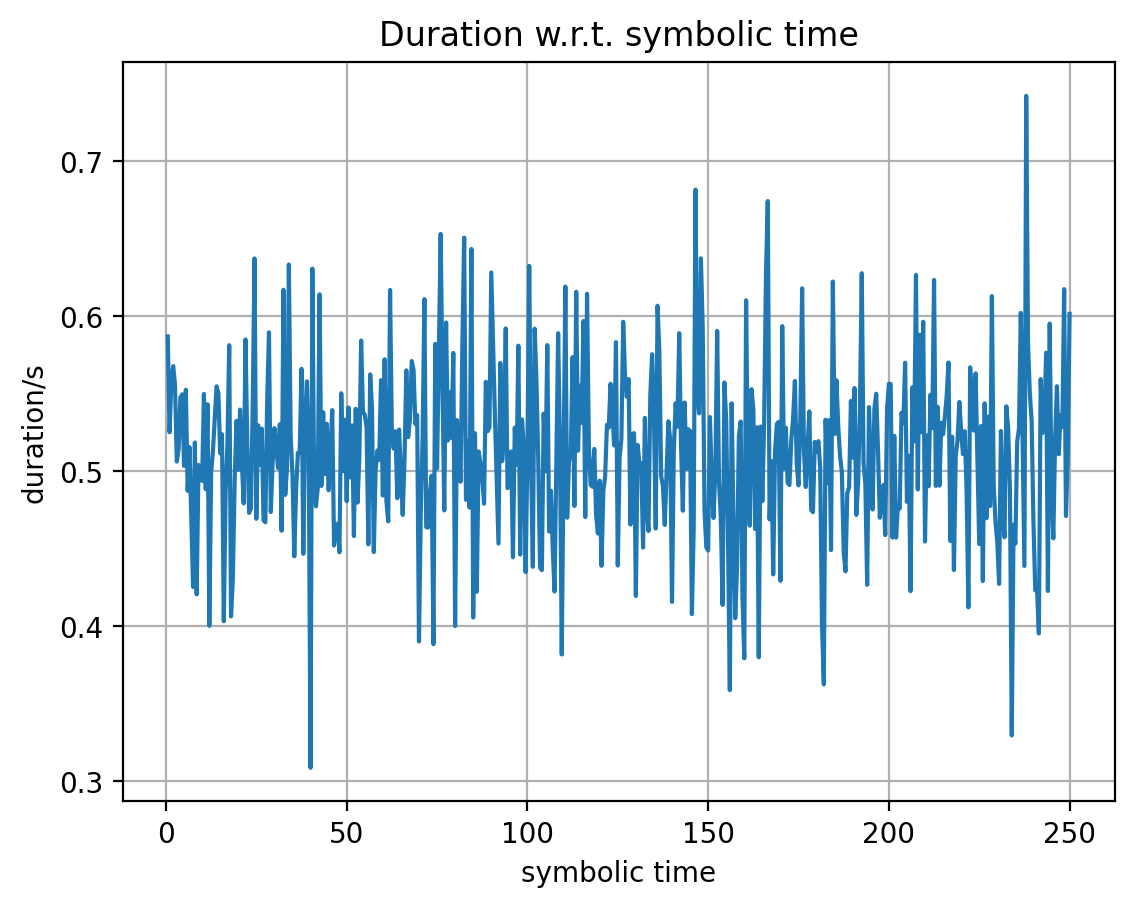

In [15]:
symbolic_duration = [0.5] * 500
durations = timing('4/4', symbolic_duration)

x = np.cumsum(symbolic_duration)
y = durations

plt.plot(x, y)

plt.xlabel('symbolic time')
plt.ylabel('duration/s')
plt.title('Duration w.r.t. symbolic time')

plt.grid(True)
plt.show()

# Task B

In [16]:
path = "asap-dataset/Bach/Prelude/"

all_note_onsets = {}
file_counts = {}

# Looping through ".musicxml"-files in subfolders
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".musicxml"):
            # Load file
            score = converter.parse(os.path.join(root, file))
            
            # Get time signature and add 1 to file count
            time_signature = score.flatten().getElementsByClass('TimeSignature')[0].ratioString
            file_counts[time_signature] = file_counts.get(time_signature, 0) + 1

            # Initialize dictionary entry for time signature
            if time_signature not in all_note_onsets:
                all_note_onsets[time_signature] = {}
            
            note_onsets = all_note_onsets[time_signature]

            # Extract note onset frequencies for the current file and add to time signature
            for part in score.parts:
                for measure in part.getElementsByClass('Measure'):
                    for element in measure.flatten():
                        if 'Note' in element.classes:
                            onset = element.offset
                            if onset in note_onsets:
                                note_onsets[onset] += 1
                            else:
                                note_onsets[onset] = 1

# Sort time signatures based on file counts
sorted_time_signatures = sorted(file_counts, key=file_counts.get, reverse=True)



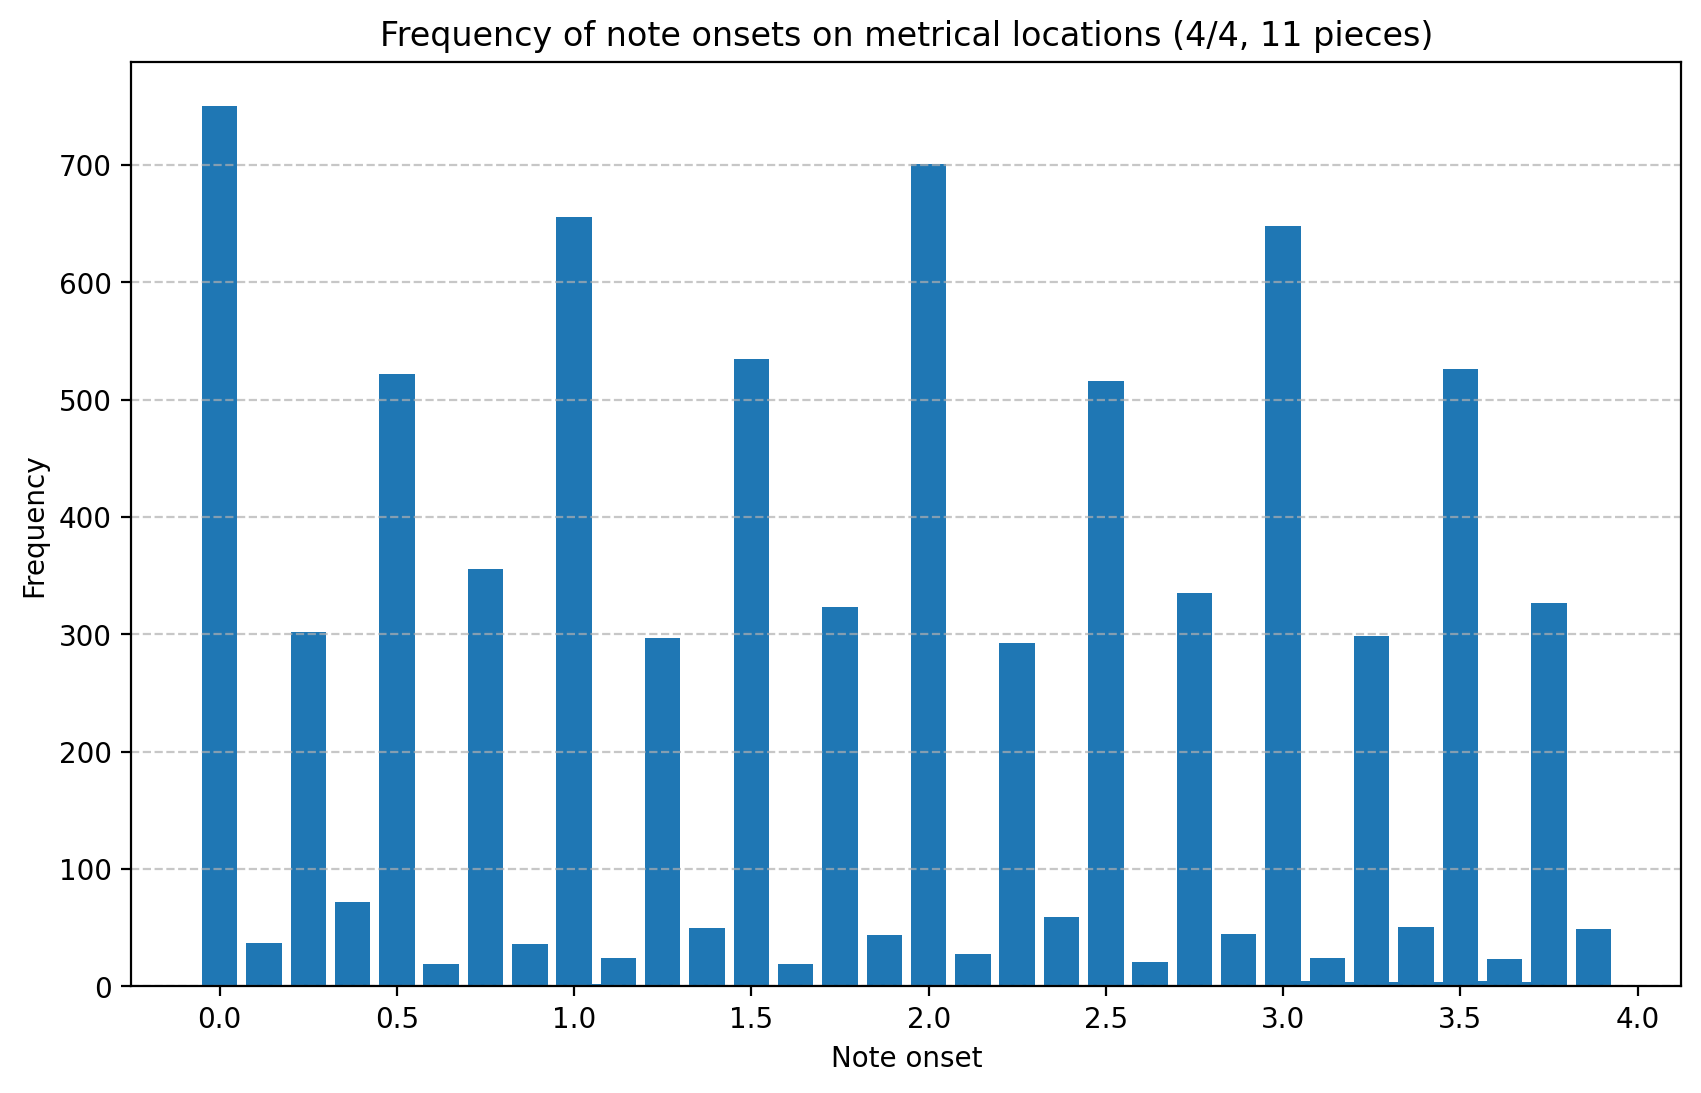

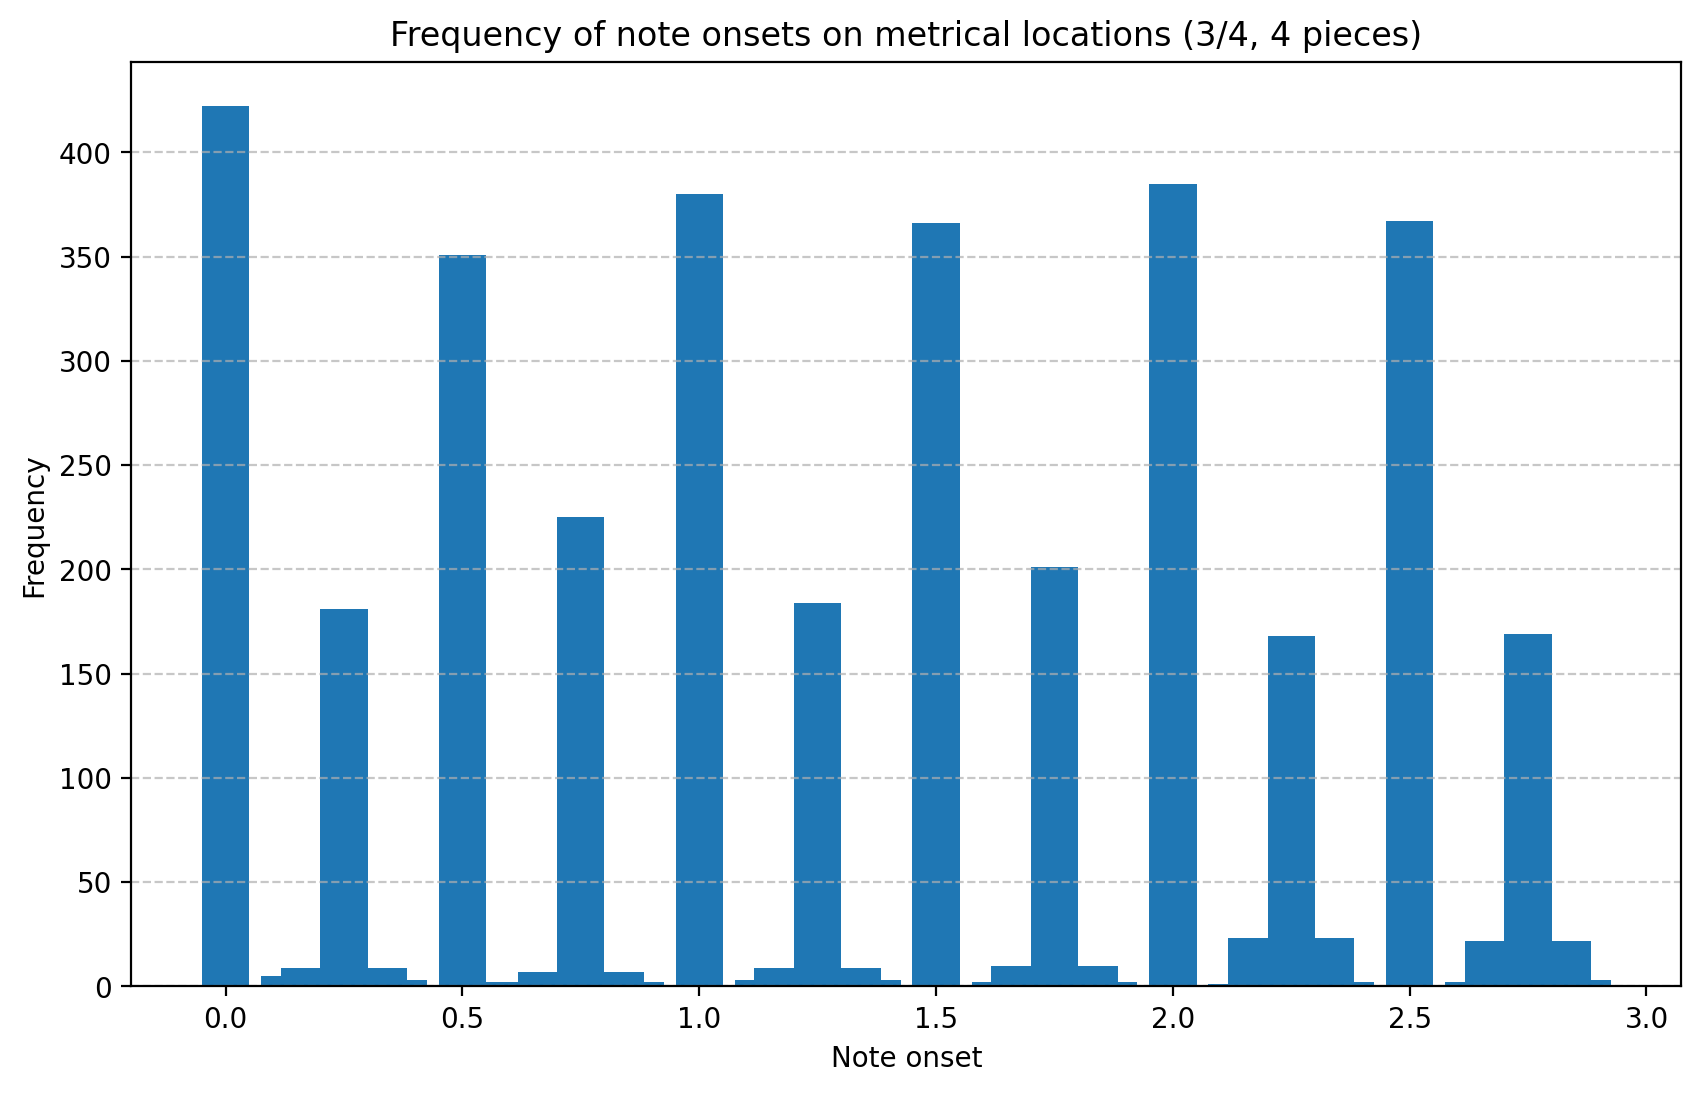

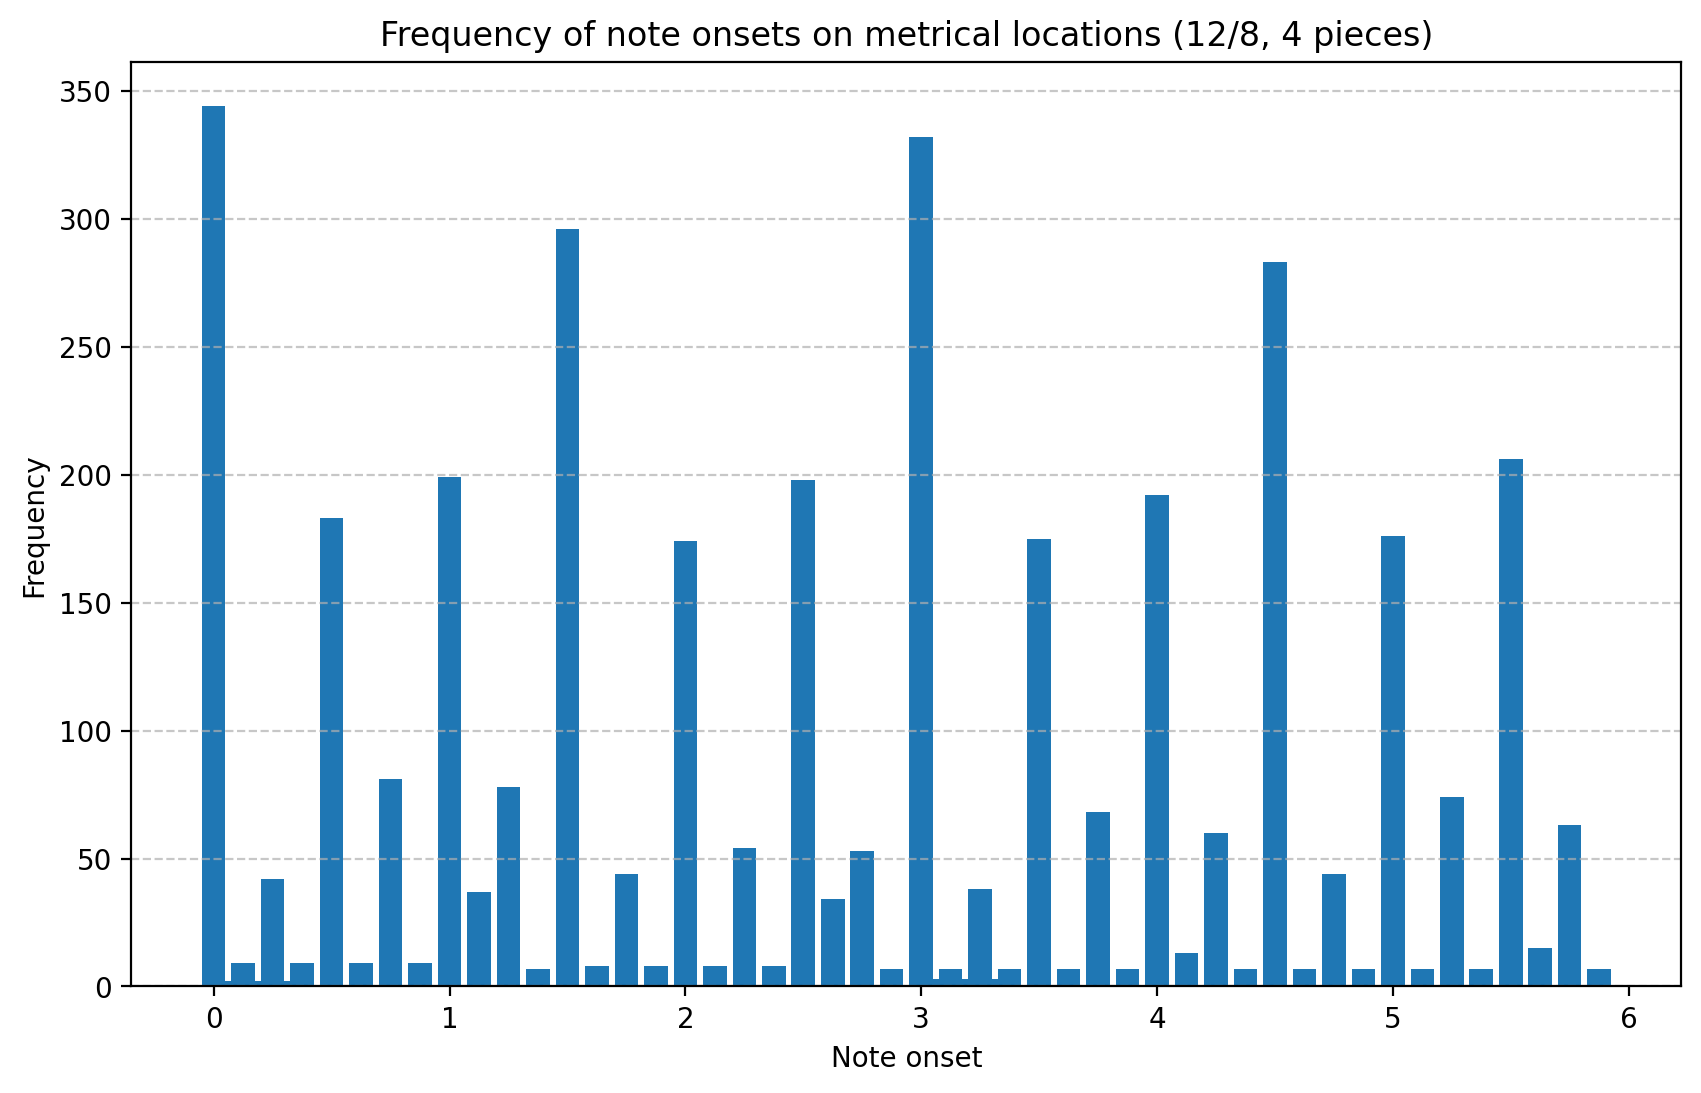

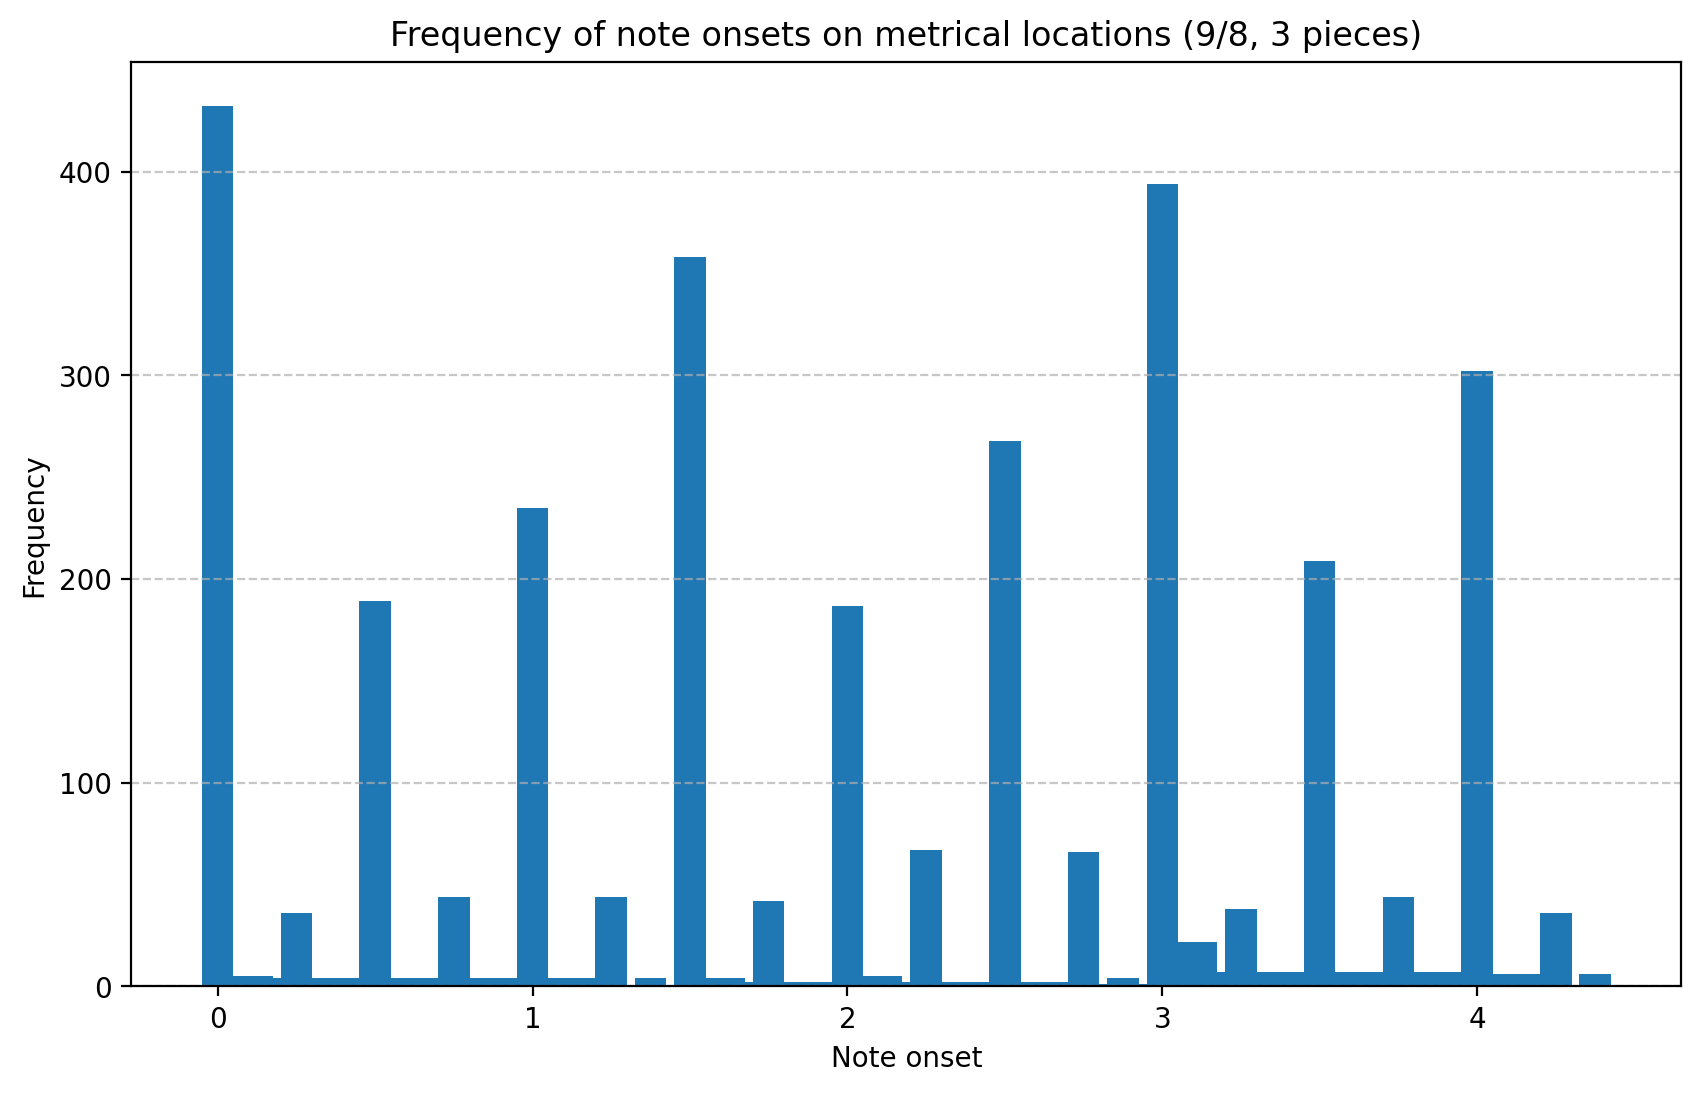

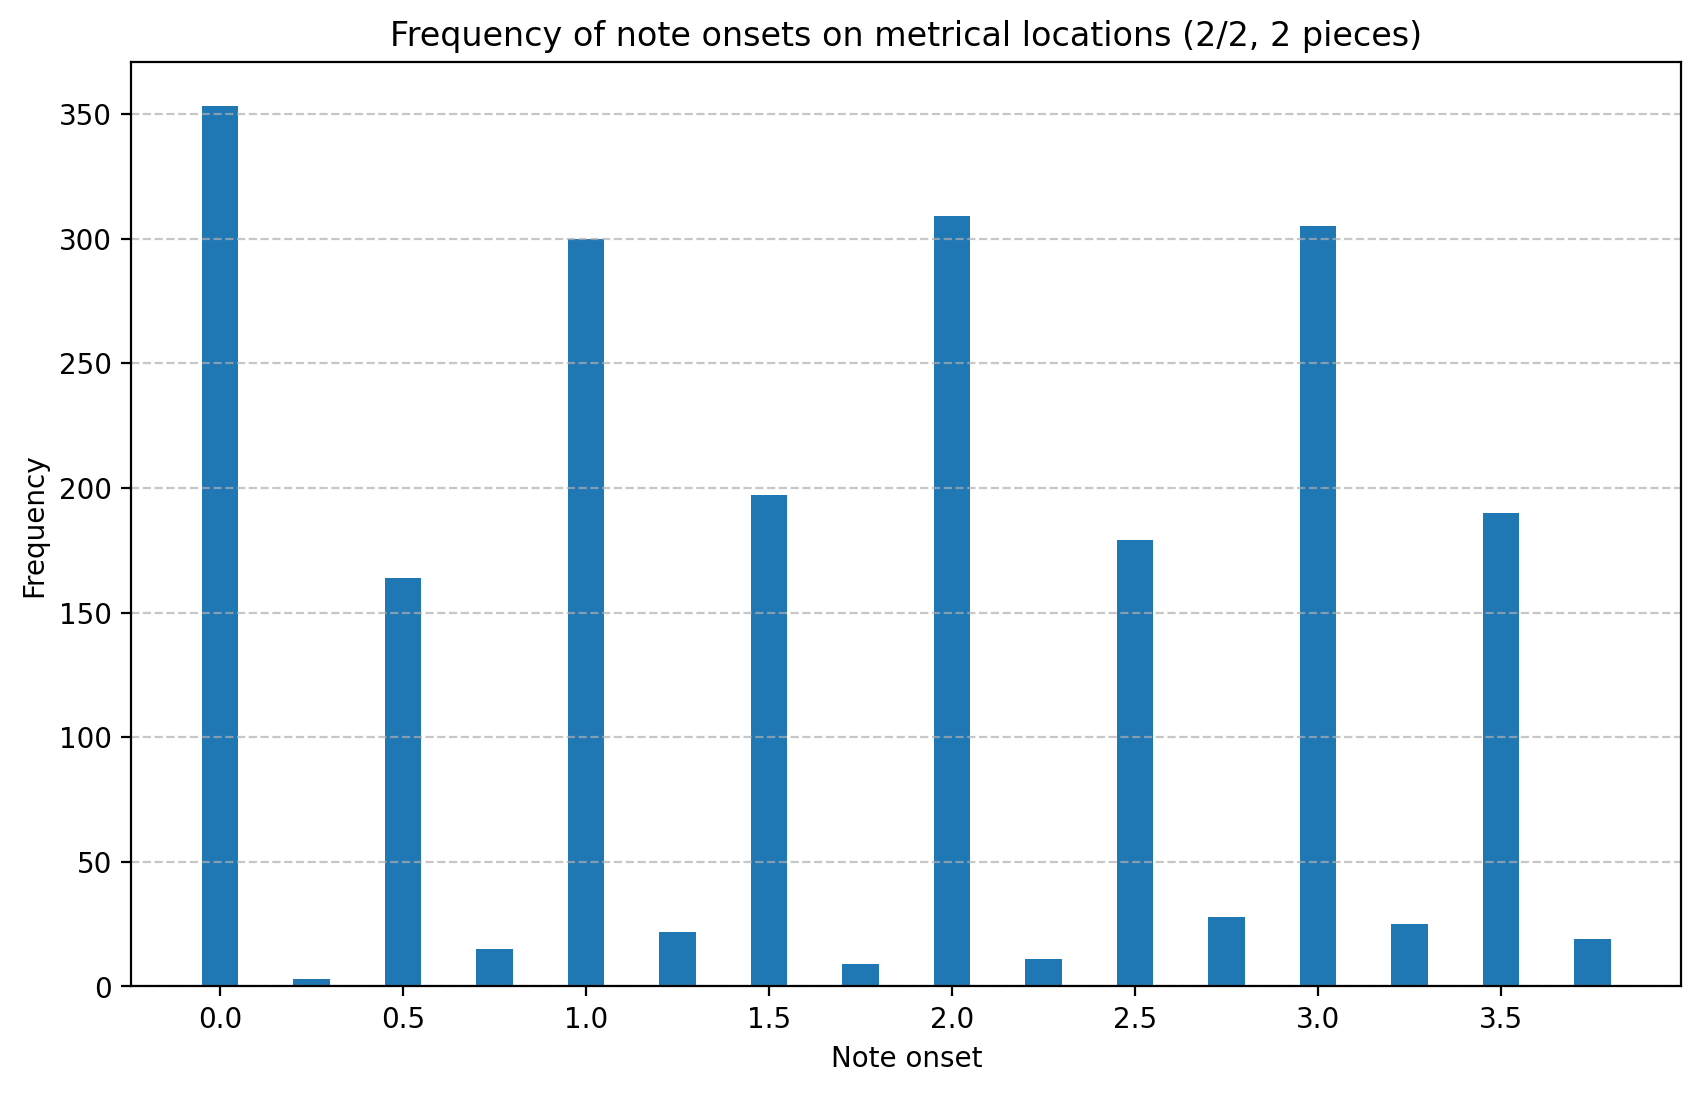

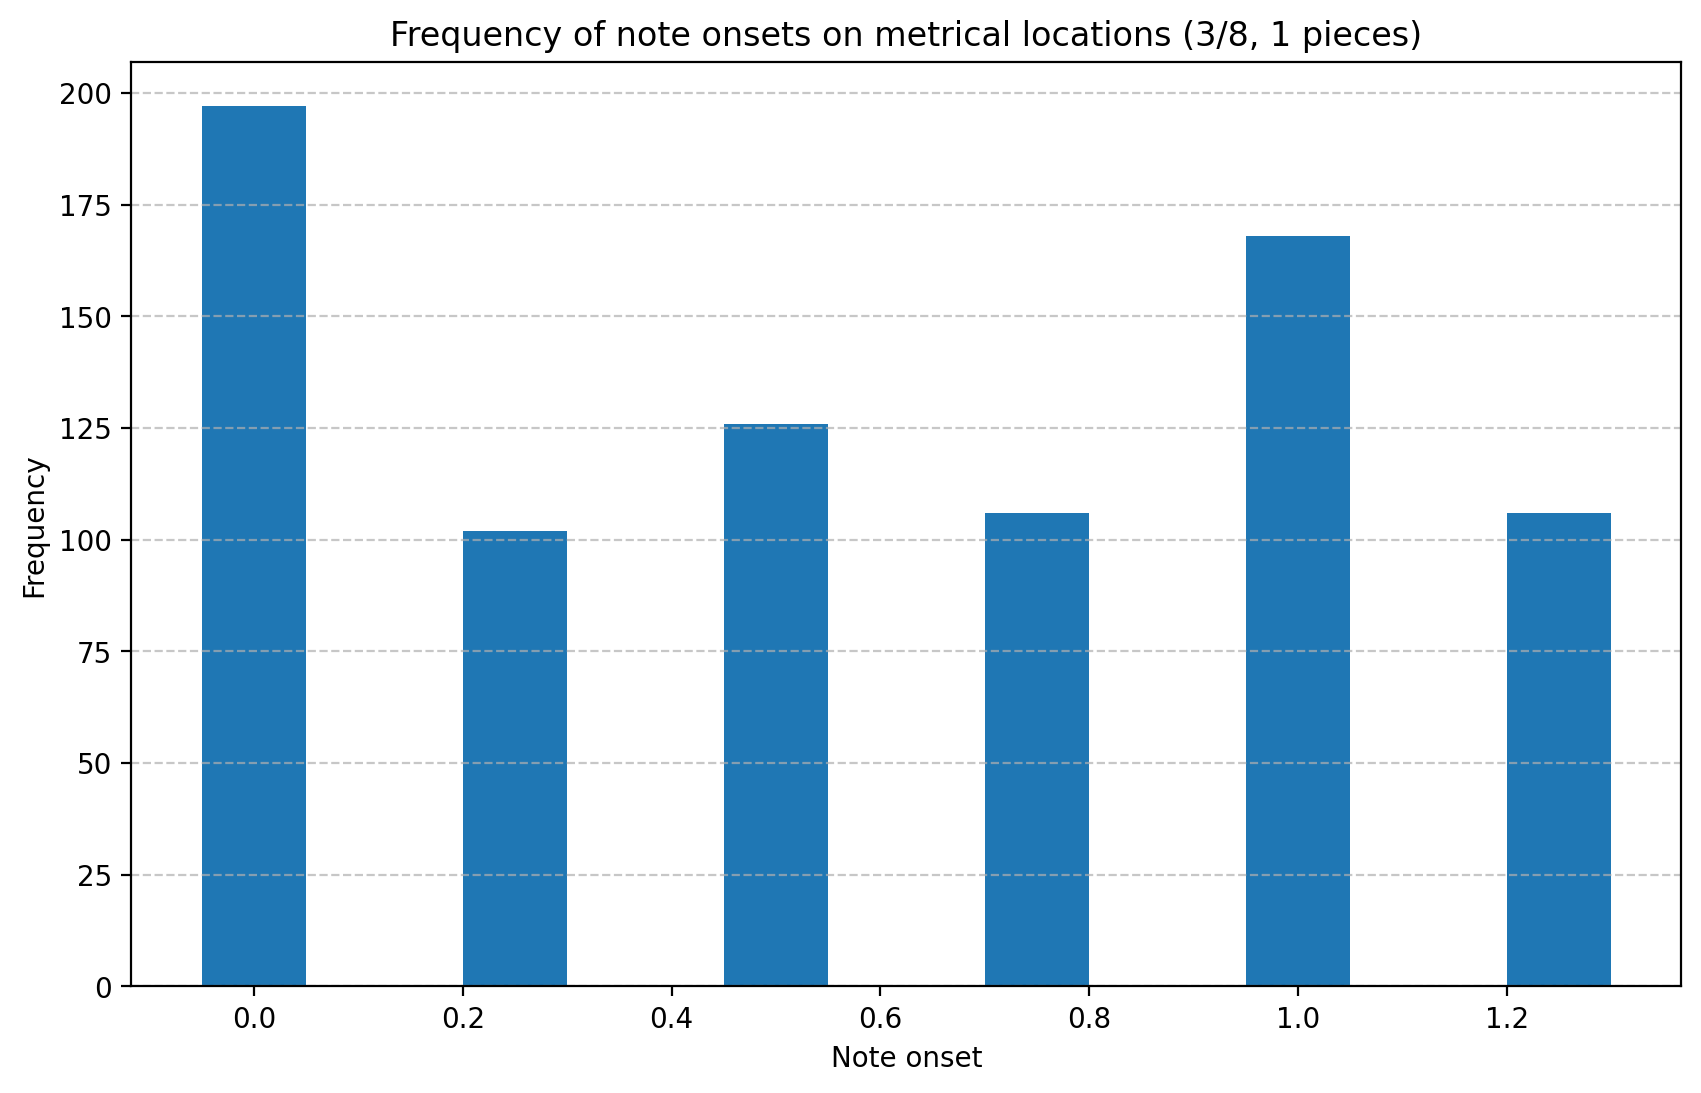

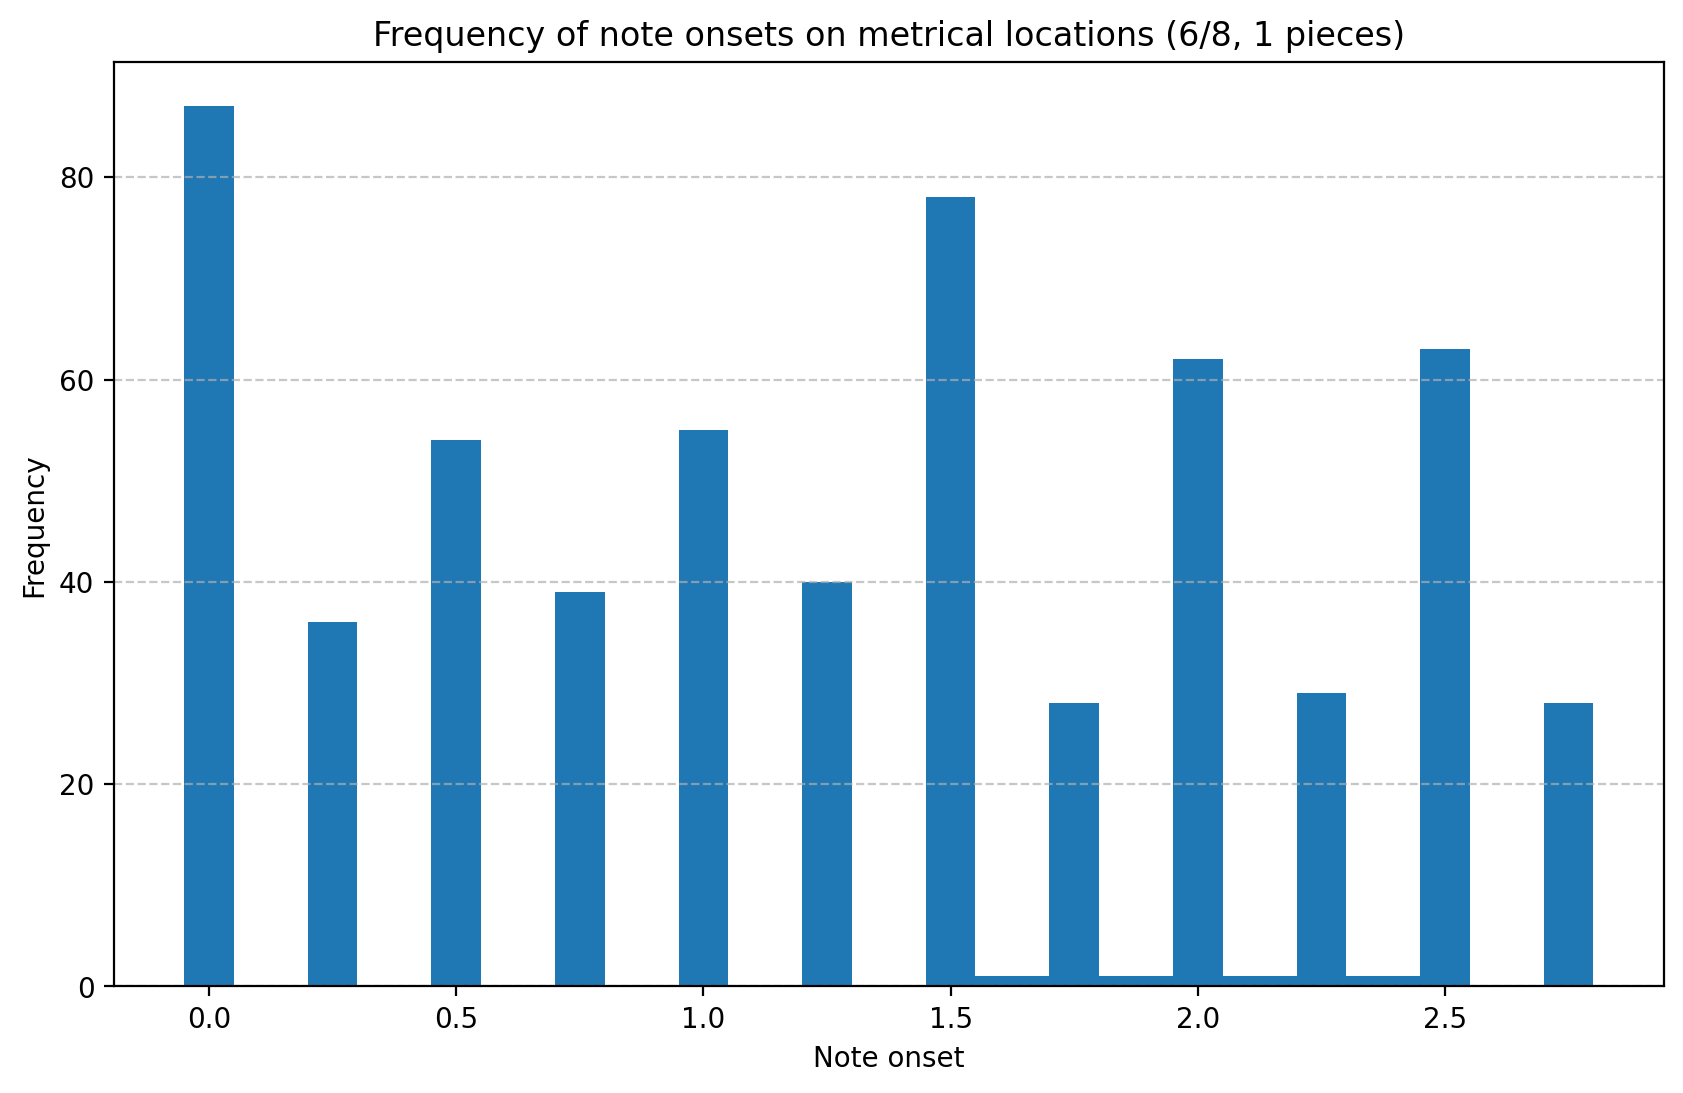

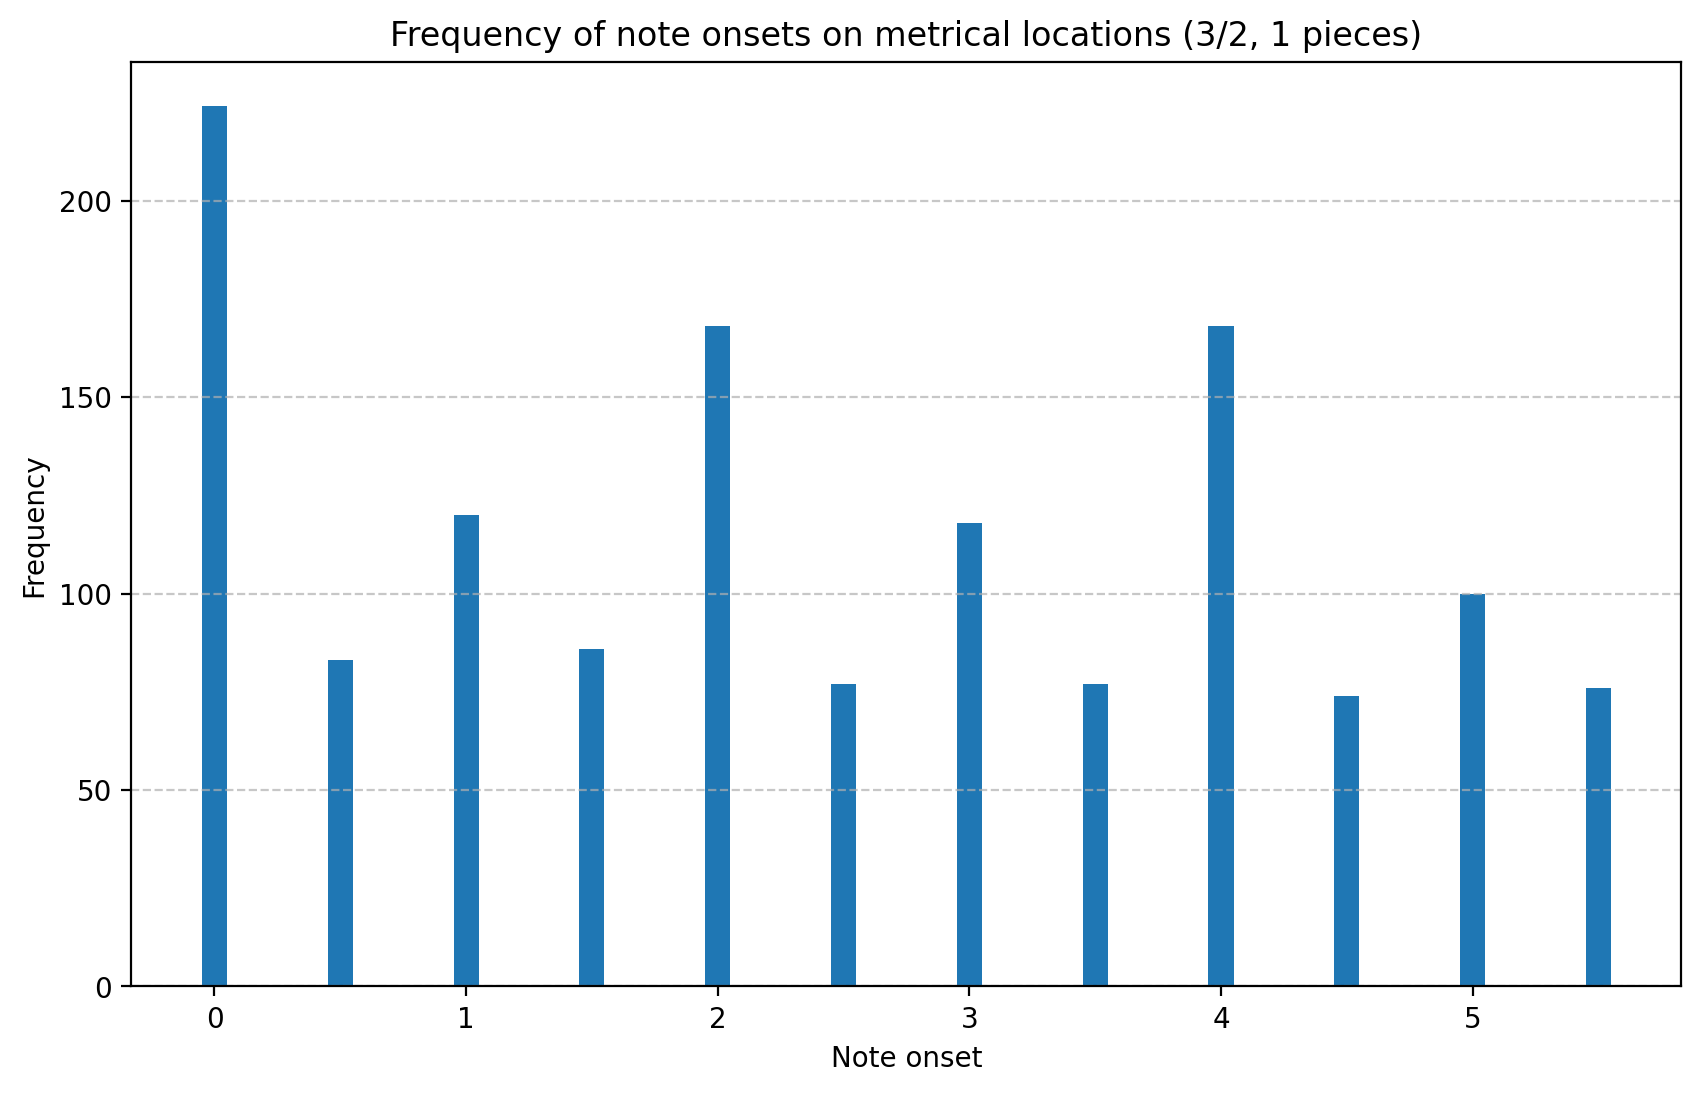

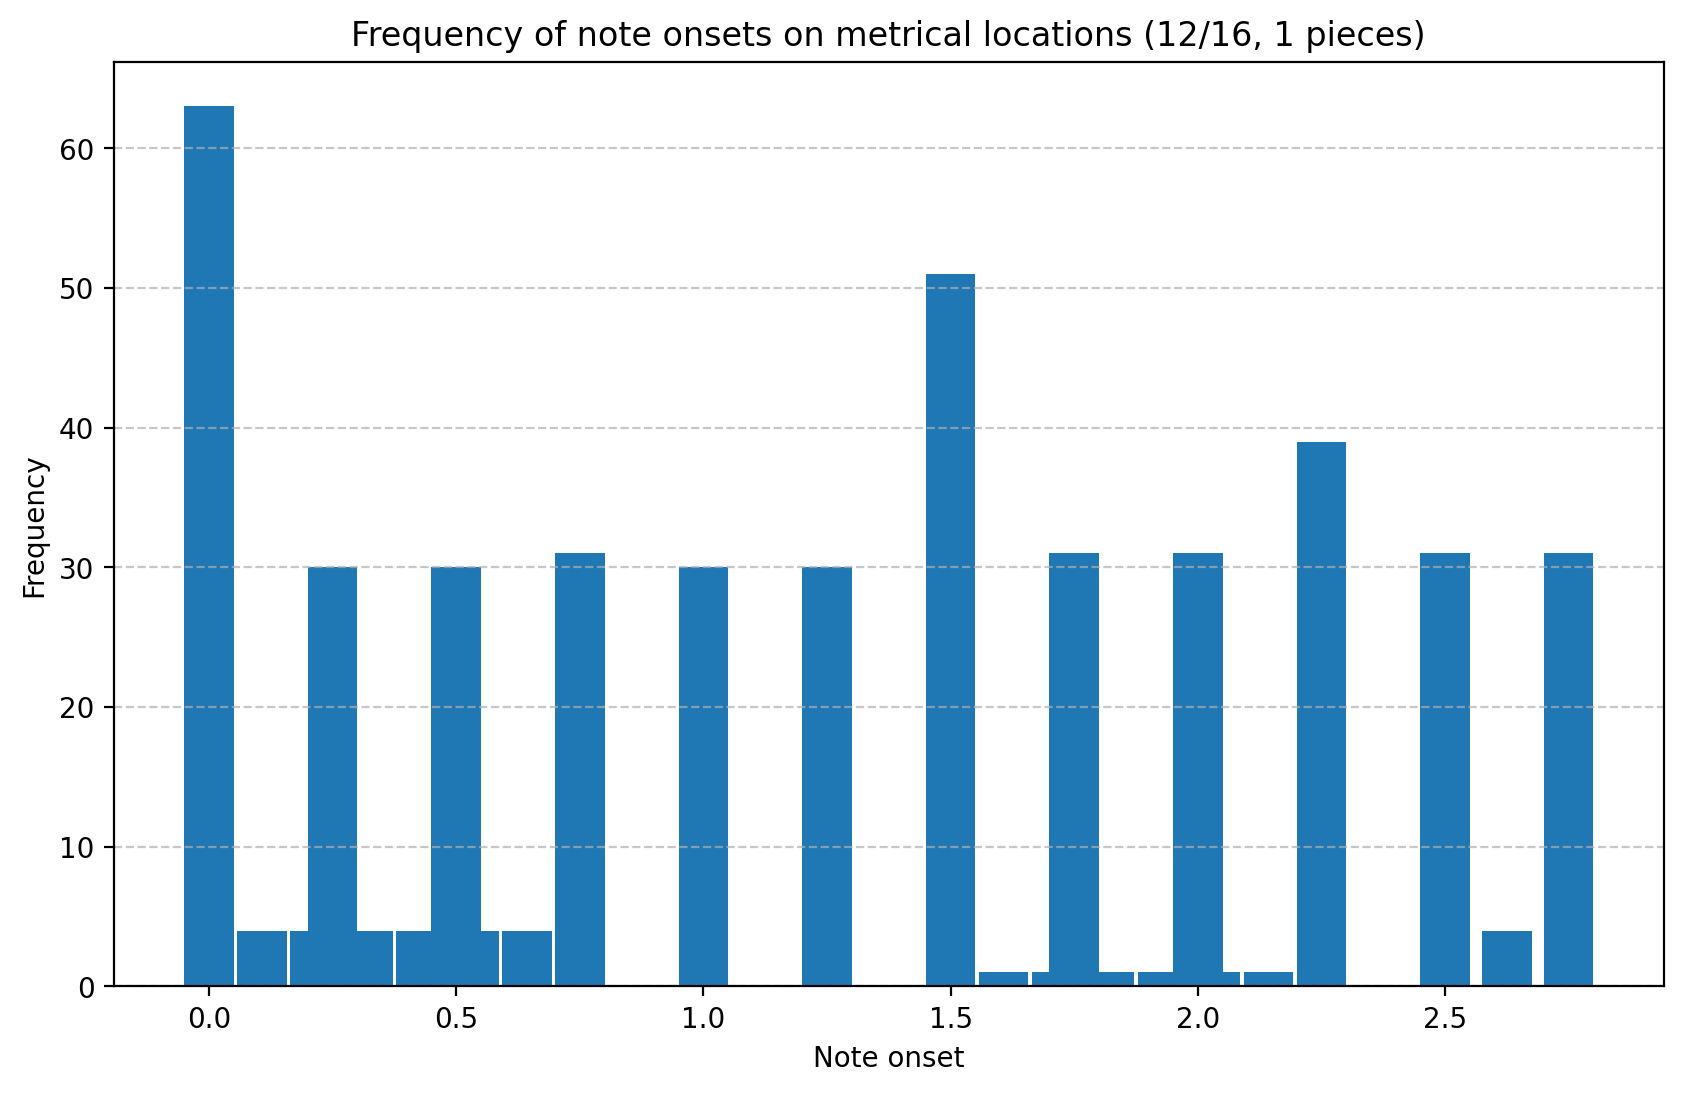

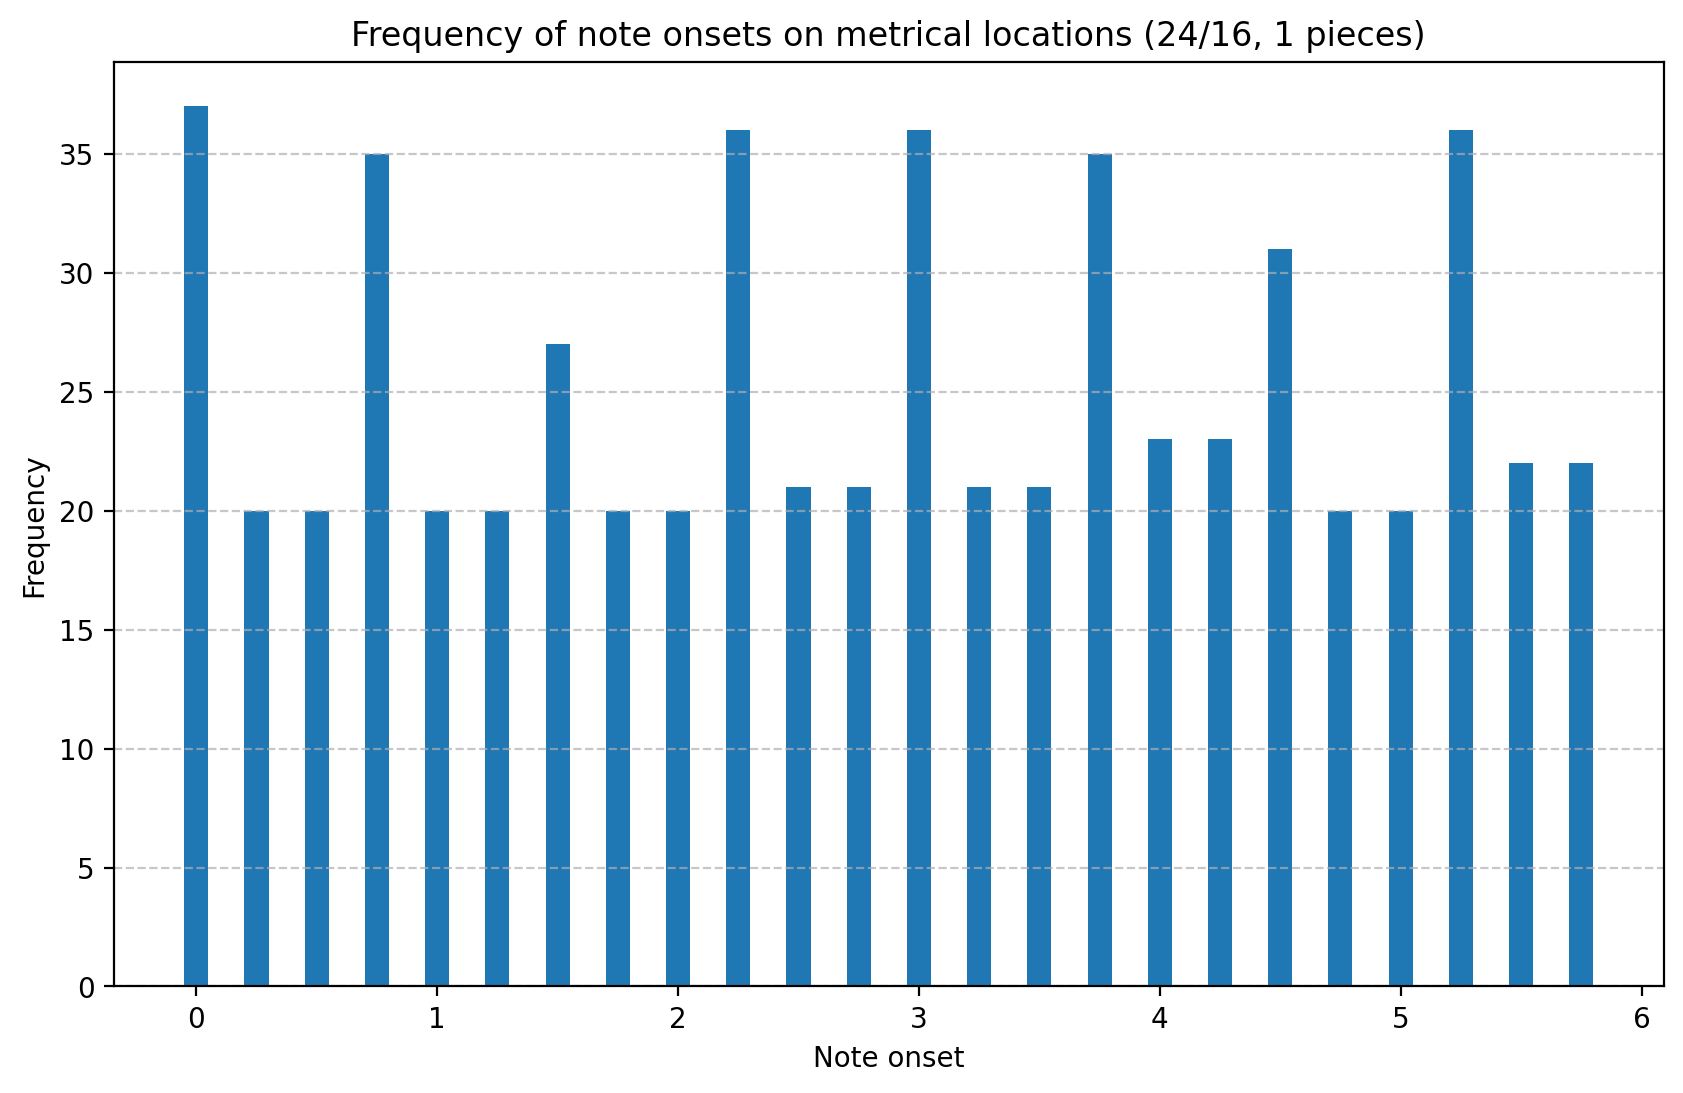

In [17]:
# Plotting note onset frequencies for each time signature
for time_signature in sorted_time_signatures:
    note_onsets = all_note_onsets[time_signature]
    plt.figure(figsize=(10, 6))
    plt.bar(note_onsets.keys(), note_onsets.values(), width=0.1)
    plt.xlabel('Note onset')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of note onsets on metrical locations ({time_signature}, {file_counts[time_signature]} pieces)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()